### Epsilon-Greedy Experiment

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.stats import t
from scipy.stats import uniform
from scipy.stats import ttest_1samp # library for p-value estimation
import ruptures as rpt # library for change point detection
import matplotlib.patheffects as mpe
%matplotlib inline
%run ./Experiment_Functions.ipynb
# load functions for the creation of the different distributions

In [12]:
# define arms
def quick_sort(df):
    sorted_df = df.sort_values(kind="quicksort")
    return sorted_df
def merge_sort(df):
    sorted_df = df.sort_values(kind="mergesort")
    return sorted_df
def heap_sort(df):
    sorted_df = df.sort_values(kind="heapsort")
    return sorted_df

In [13]:
choices = [quick_sort,merge_sort,heap_sort]
choices_names = ["quick_sort","merge_sort","heap_sort"]
dist_types = ["Uniform","Normal","Uniform_Sorted","Uniform_Reverse_Sorted","Uniform_Nearly_Sorted","Zipf", "Dates", "Strings", "Discrete_Uniform", "Discrete_Binomial", "Poisson"]

In [14]:
# Define different number of samples for different experiments
n_samples_1e5 = 100000
n_samples_5e4 = 50000
n_samples_5e5 = 500000

In [15]:
# Define the settings of  the 5 different experimental set-ups
list_distributions_1 = 1000*["Discrete_Uniform"] + 1000*["Uniform_Sorted"] 
# list_distributions_1 with n_samples_1e5
list_distributions_2 = 50*["Discrete_Uniform"] +  50*["Uniform_Sorted"]  
# list_distributions_2 with n_samples_5e5
list_distributions_3 = 1000*["Discrete_Uniform"] +  1000*["Uniform_Sorted"] + 1000*["Discrete_Binomial"] + 1000*["Uniform_Reverse_Sorted"]
# list_distributions_3 with n_samples_5e4
list_distributions_4 = 100*["Uniform_Sorted"] +  50*["Poisson"] + 100*["Uniform_Reverse_Sorted"] + 50*["Zipf"]
# list_distributions_4 with n_samples_1e5
list_distributions_5 = 50*["Uniform_Sorted"] +  50*["Poisson"] + 50*["Uniform_Reverse_Sorted"] + 50*["Zipf"] +  50*["Uniform_Reverse_Sorted"] + 50*["Discrete_Uniform"]
# list_distributions_5 with n_samples_1e5

In [16]:
def plot_history(rewards,cum_rewards,chosen_arms):

    fig = plt.figure(figsize=[16,6])
    ax2 = fig.add_subplot(121)
    ax2.plot(cum_rewards, label="avg rewards")
    ax2.set_title("Cummulative Rewards",fontsize=18)
    ax2.set_ylabel('Reward (multiplied by -1)',fontsize=16)
    ax2.set_xlabel('Iteration',fontsize=16)
    plt.setp(ax2.get_xticklabels(), fontsize=14)
    plt.setp(ax2.get_yticklabels(), fontsize=14)
    labels = list(chosen_arms.keys())
    ax3 = fig.add_subplot(122)
    ax3.bar(chosen_arms.keys(), chosen_arms.values())
    ax3.set_title("Chosen Actions",fontsize=18)
    ax3.set_ylabel('Frequency',fontsize=16)
    ax3.set_xlabel('Action',fontsize=16)
    plt.setp(ax3.get_xticklabels(), fontsize=14)
    plt.setp(ax3.get_yticklabels(), fontsize=14)

In [17]:
def plot_history_iterations(history):
    df = pd.DataFrame.from_records(history,columns=["Iteration","Reward","Algorithm"])
    df["Reward"] = df["Reward"]*(-1)
    groups = df.groupby('Algorithm')
    # Plot
    x_values_1 = [0, 49]
    y_values_1 = [0.04317895799999931,0.04317895799999931]
    x_values_2 = [50, 100]
    y_values_2 = [0.022832142000008843,0.022832142000008843]
    dict_colors = {"quick_sort":'#1f77b4', "merge_sort":'#ff7f0e', "heap_sort":'#2ca02c'}
    plt.figure(figsize=(16,6))
    for name, group in groups:
        plt.plot(group.Iteration, group.Reward, marker='o', linestyle='', ms=10, alpha = 0.5, label=name, color=dict_colors[name])
    plt.plot(x_values_1, y_values_1, marker = 'o', markersize=10, color = '#1f77b4', linewidth=1, label="Optimal Solution Quick Sort", path_effects= [mpe.Stroke(linewidth=3, foreground='black')], alpha = 0.5)
    plt.plot(x_values_2, y_values_2, marker = 'o', markersize=10, color = '#ff7f0e', linewidth=1, label="Optimal Solution Merge Sort", path_effects= [mpe.Stroke(linewidth=3, foreground='black')], alpha = 0.5)
    
    
    plt.legend(fontsize=26, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title("Algorithm choices during experiment",fontsize=26)
    plt.ylabel("Runtime in seconds",fontsize=26)
    plt.xlabel("Iteration",fontsize=26)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)

In [18]:
def plot_rewards_distribution_together(arm_rewards, bins = 20):
    plt.figure(figsize=(16,6))
    plt.hist(arm_rewards["quick_sort"], bins, alpha = 0.5, label='quick sort')
    plt.hist(arm_rewards["merge_sort"], bins, alpha = 0.5, label='merge sort')
    plt.hist(arm_rewards["heap_sort"], bins, alpha = 0.5, label='heap sort')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5) ,fontsize=26)
    plt.title("Distribution of runtimes during experiment",fontsize=26)
    plt.ylabel("Frequency",fontsize=26)
    plt.xlabel("Runtime in seconds (multiplied by -1)",fontsize=26)
    plt.xticks(fontsize=26)
    plt.yticks(fontsize=26)

In [19]:
def epsilon_greedy(list_distributions, n_samples, epsilon=0.01, constant_value=0.01):
    total_reward = 0
    num_choices = len(choices)
    arm_rewards = {"quick_sort": [], "merge_sort": [], "heap_sort":[]} 
    arm_counts = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0} 
    q_values = {"quick_sort": 0, "merge_sort": 0, "heap_sort":0} 
    rewards = []
    cum_rewards = []
    history = []
    iteration = 0
    for n, elem in enumerate(list_distributions):
        dist_type = elem
        distribion =  create_df_distribution(n_samples=n_samples, dist_type=dist_type)
        alg = np.random.choice(choices) if np.random.random() < epsilon else choices[np.argmax(list(q_values.values()))]
        #print(alg)
        start_time = time.perf_counter()
        sorted_dist = alg(distribion[dist_type])
        reward = (time.perf_counter() - start_time)*(-1)
        #print(iteration, ":", alg.__name__, np.round(reward,4))
        total_reward += reward
        arm_rewards[alg.__name__].append(reward)
        arm_counts[alg.__name__] += 1
        q_values[alg.__name__]  += constant_value*(reward-q_values[alg.__name__])
        rewards.append(reward)
        cum_rewards.append(sum(rewards)/len(rewards))
        iteration+=1
        history.append([iteration, reward,alg.__name__])
    return total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history

# For each setting we are going  to try out different values fo the parameters epsilon and the constant value:
### epsilon = 0.01, 0.05 or 0.1
### constant_value = 0.5, 0,9 or 1

## Setting 2:
### list_distributions_2 = 50*["Discrete_Uniform"] +  50*["Uniform_Sorted"]  
### list_distributions_2 with n_samples_5e5

#### epsilon = 0.01, constant_value = 0.5

Total reward -4.2328728999998475


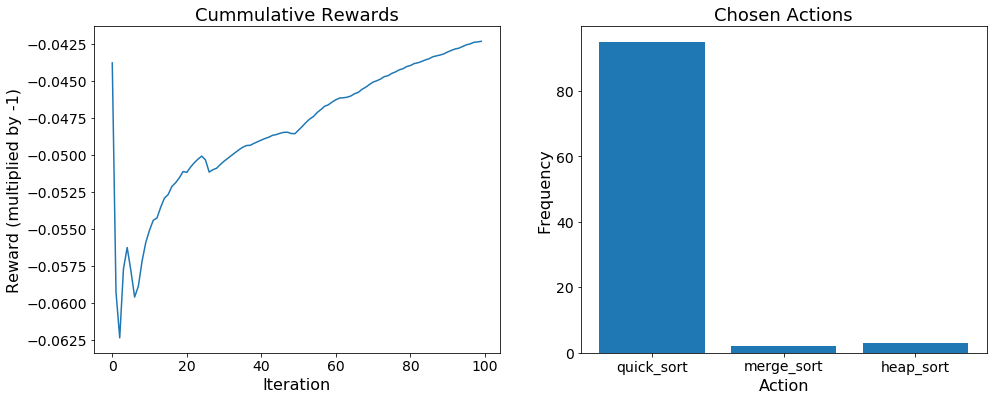

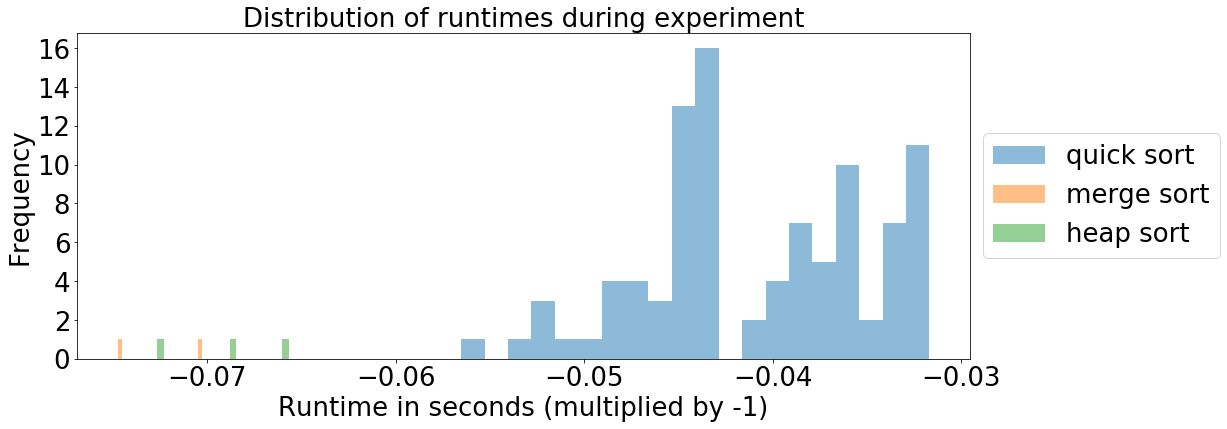

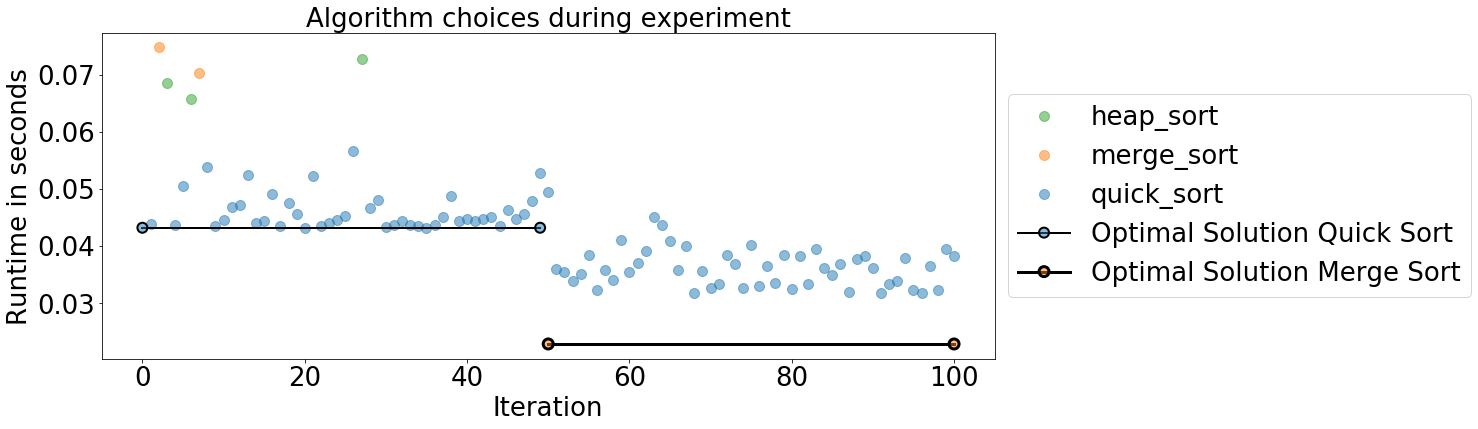

In [20]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards,history = epsilon_greedy(list_distributions_2, n_samples_5e5, epsilon=0.01, constant_value=0.5)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)

#### epsilon = 0.01, constant_value = 0.9

Total reward -4.036068200000159


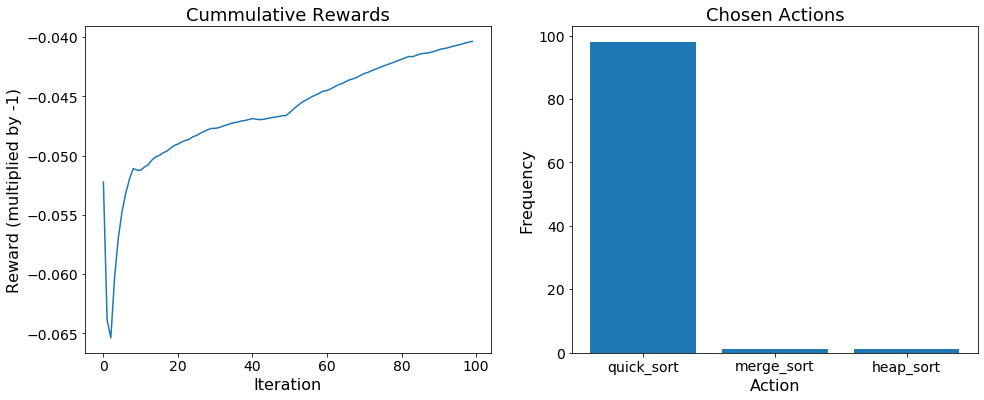

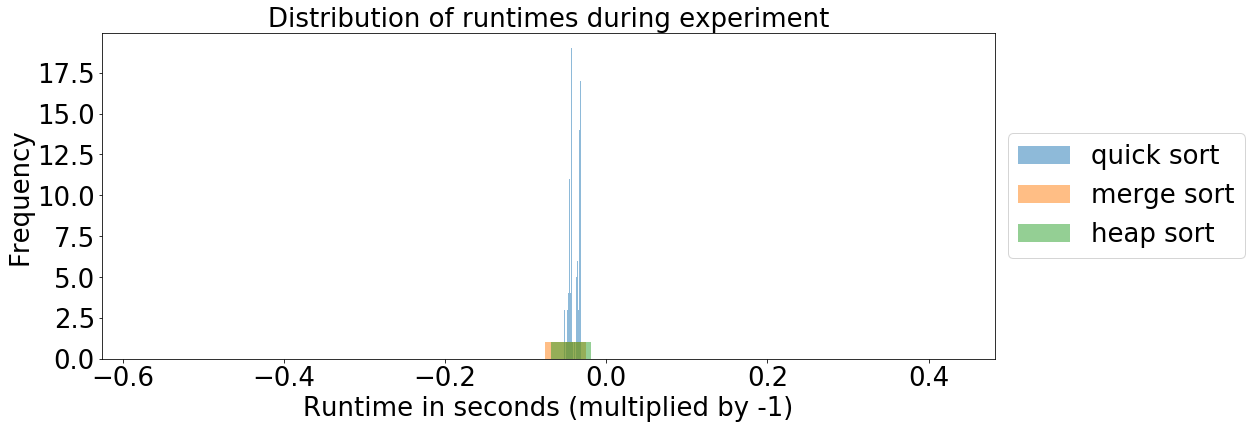

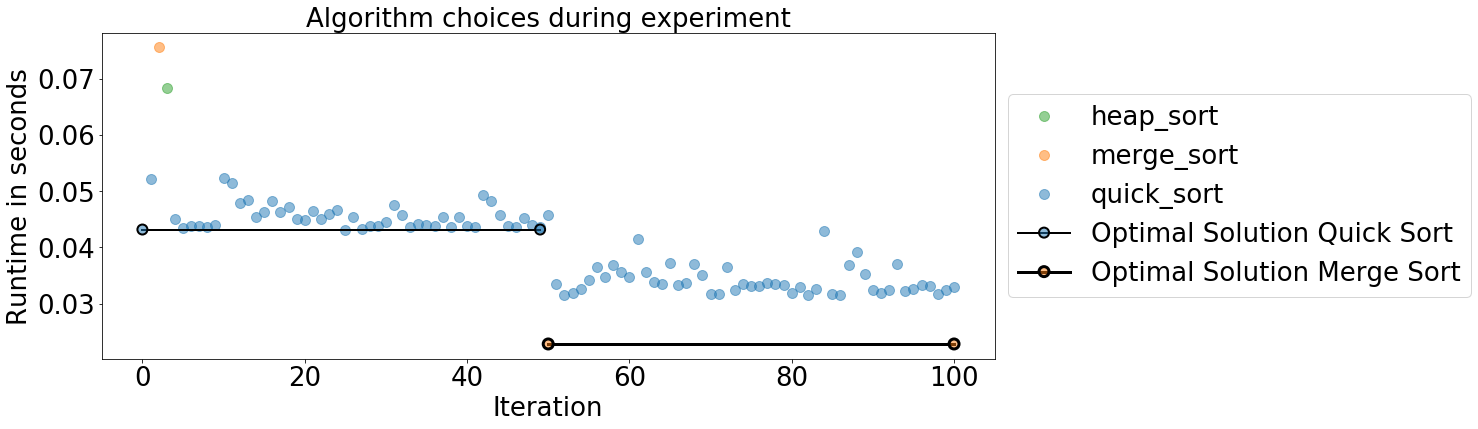

In [21]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history = epsilon_greedy(list_distributions_2, n_samples_5e5, epsilon=0.01, constant_value=0.9)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)

#### epsilon = 0.01, constant_value = 1

Total reward -4.06974630000019


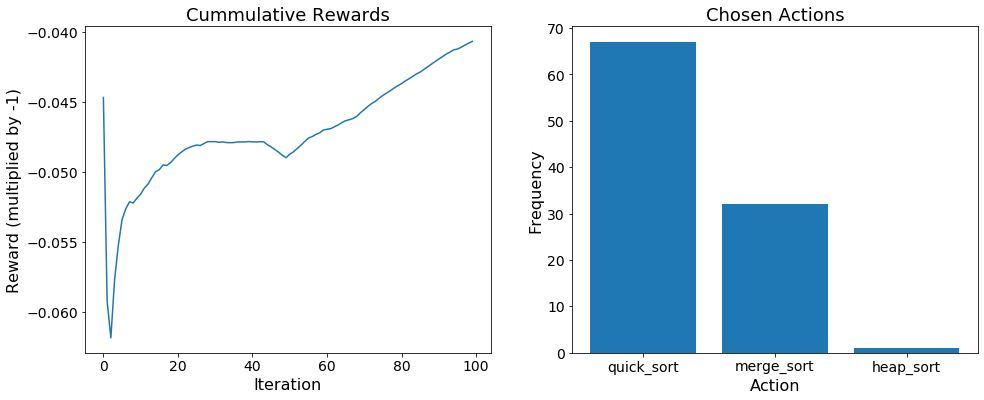

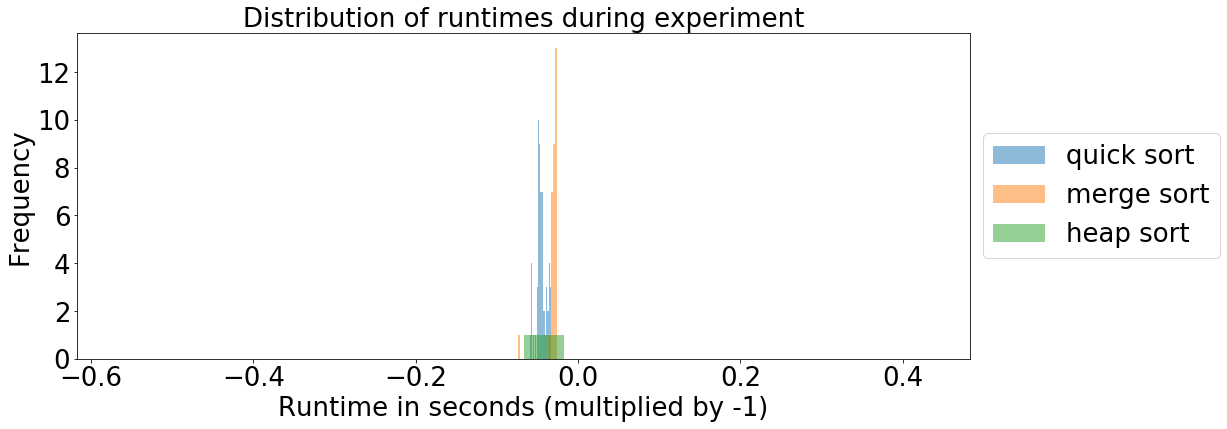

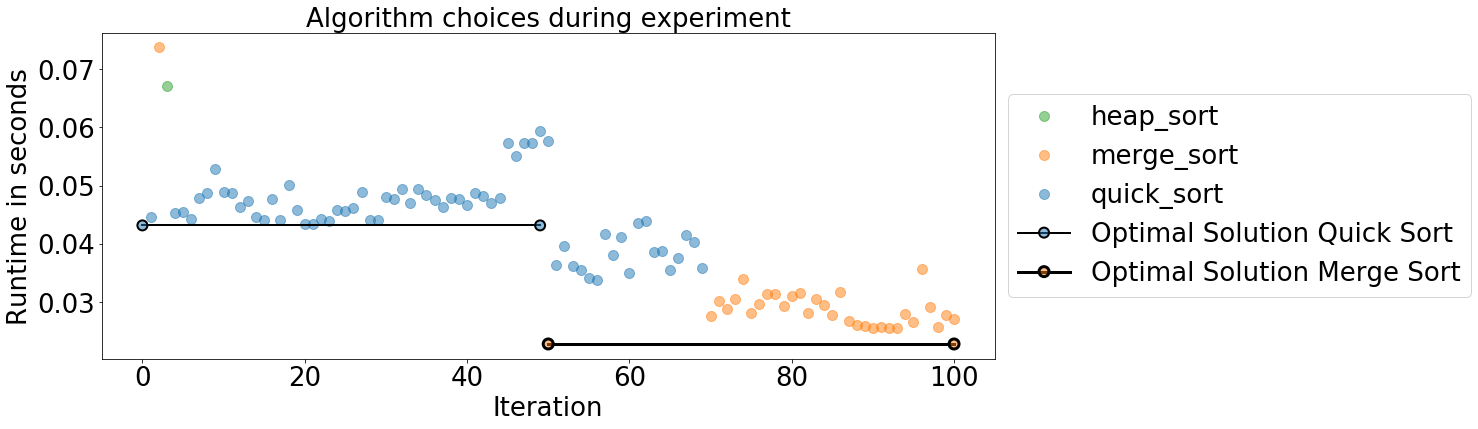

In [22]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history = epsilon_greedy(list_distributions_2, n_samples_5e5, epsilon=0.01, constant_value=1)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)

#### epsilon = 0.05, constant_value = 0.5

Total reward -4.217691600000023


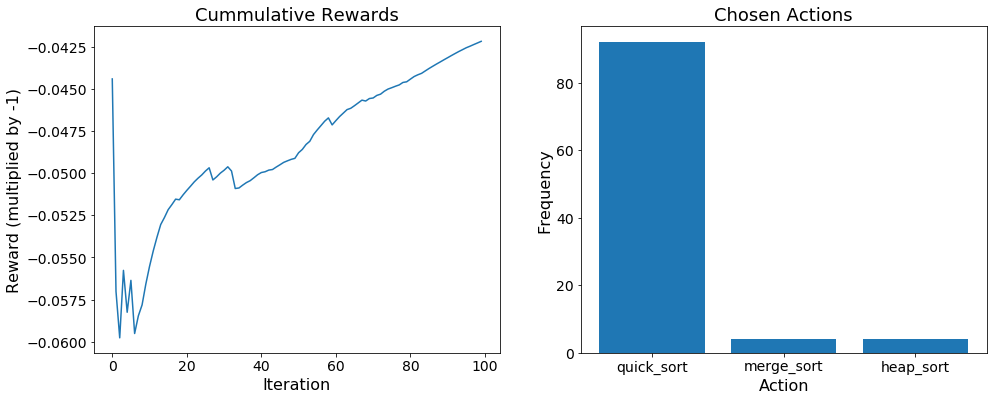

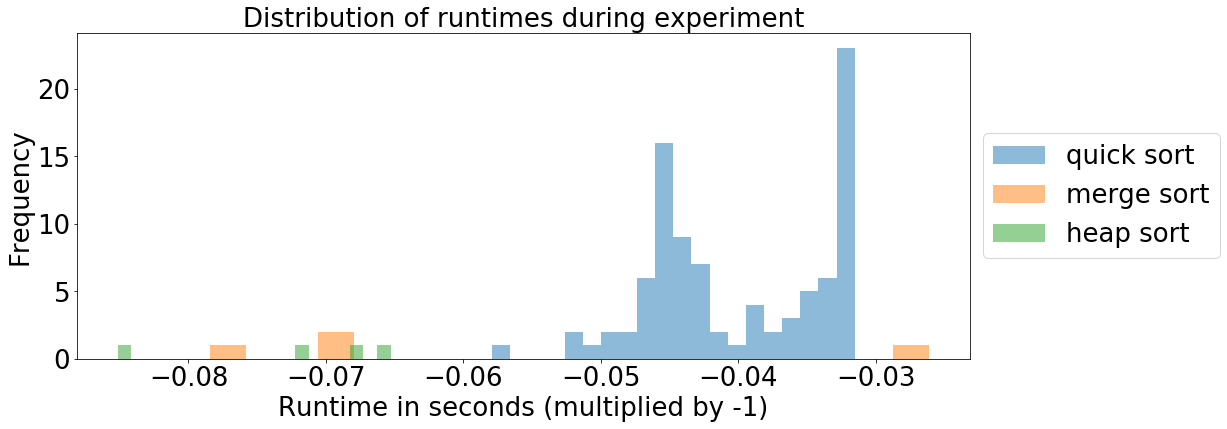

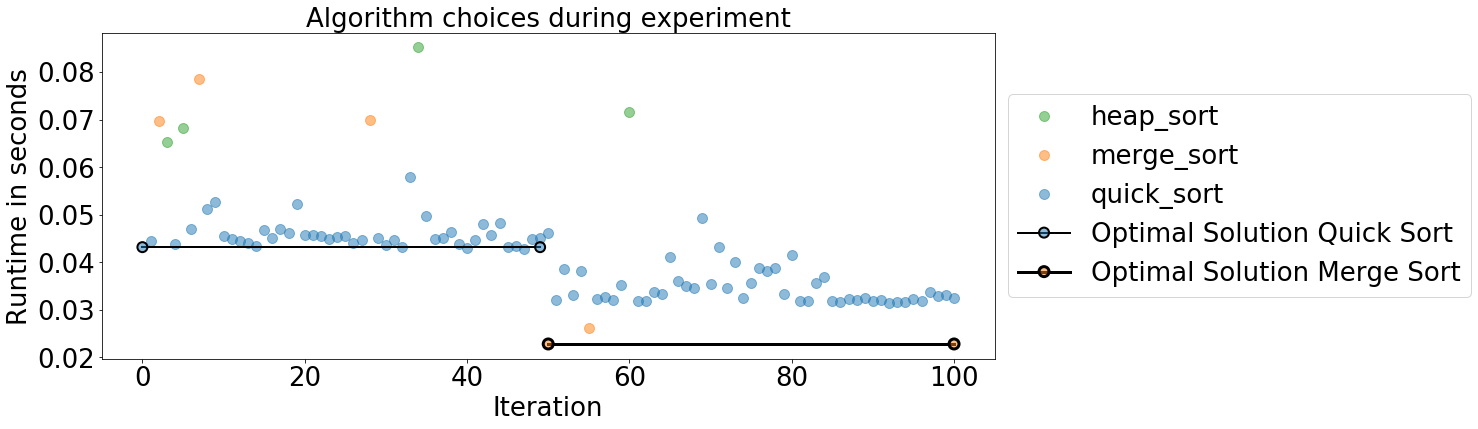

In [23]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history = epsilon_greedy(list_distributions_2, n_samples_5e5, epsilon=0.05, constant_value=0.5)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)

#### epsilon = 0.05, constant_value = 0.9

Total reward -3.99513549999989


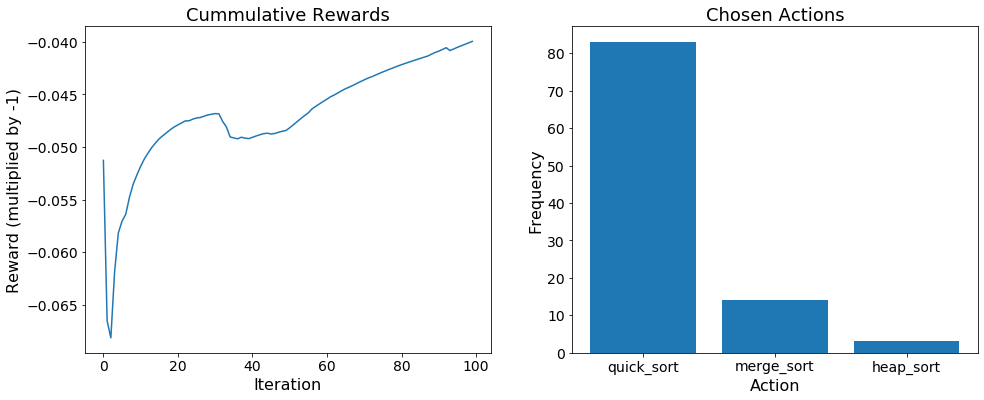

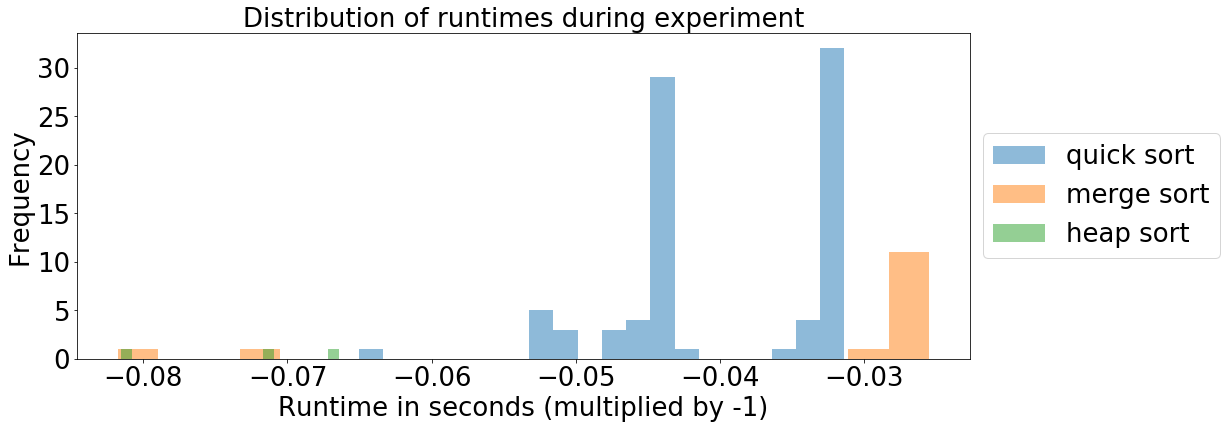

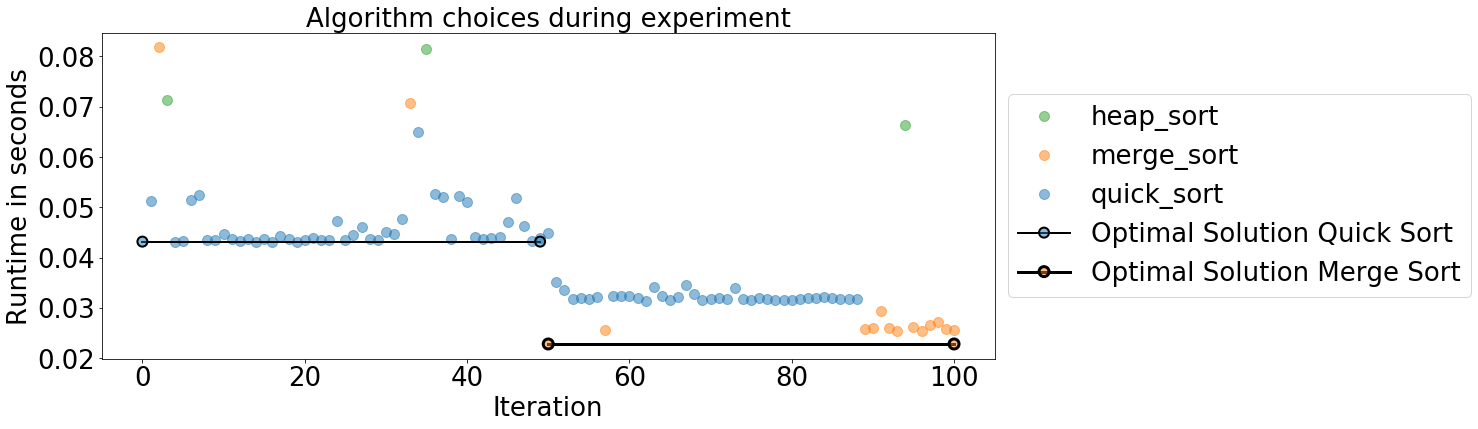

In [24]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history = epsilon_greedy(list_distributions_2, n_samples_5e5, epsilon=0.05, constant_value=0.8)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)

#### epsilon = 0.05, constant_value = 1

Total reward -3.74402630000003


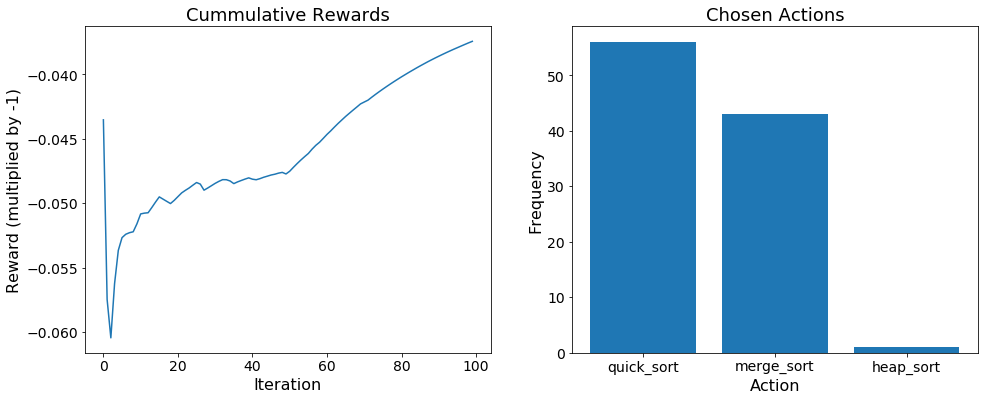

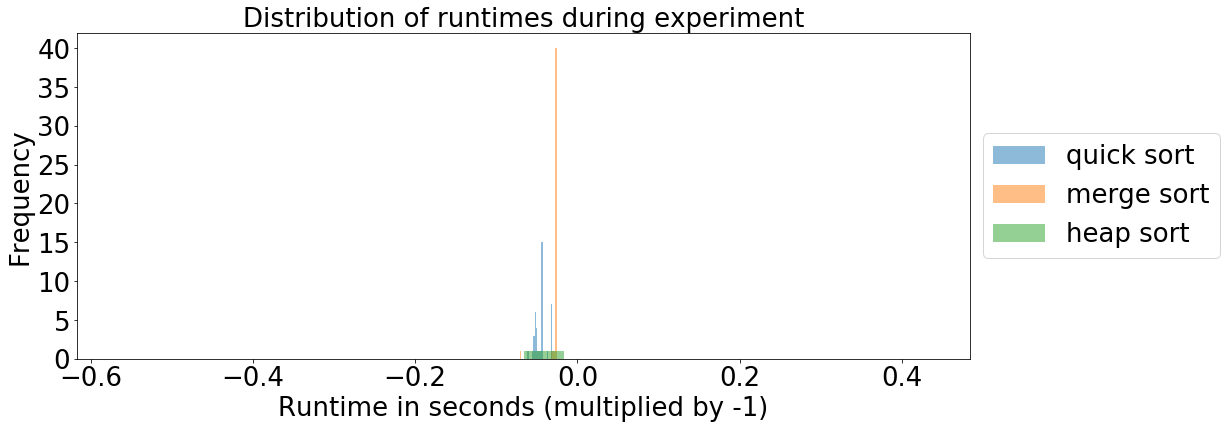

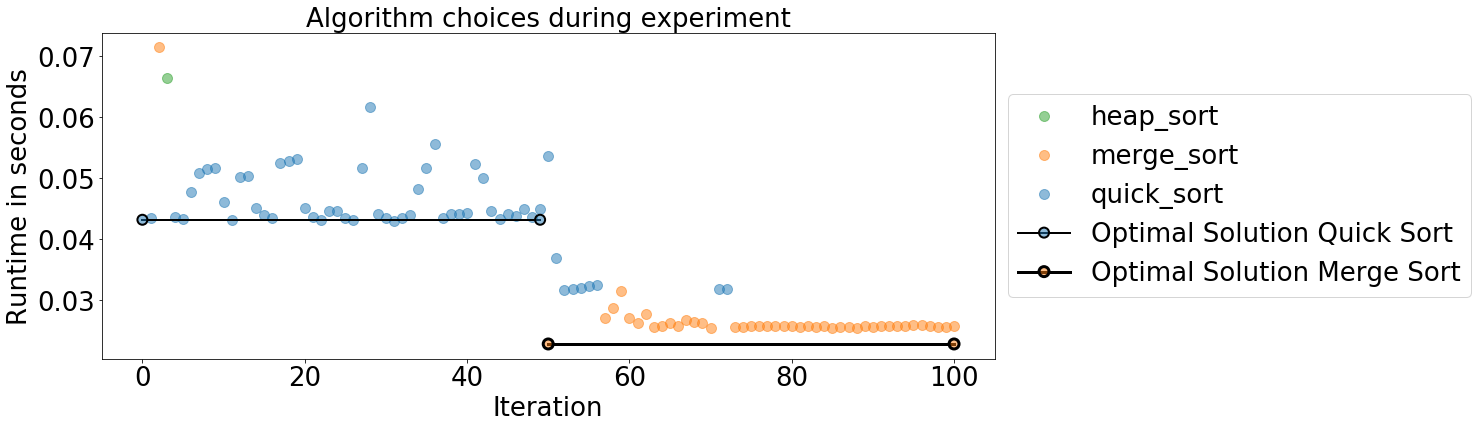

In [25]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history = epsilon_greedy(list_distributions_2, n_samples_5e5, epsilon=0.05, constant_value=1)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)

#### epsilon = 0.1, constant_value = 0.5

Total reward -4.081015199999797


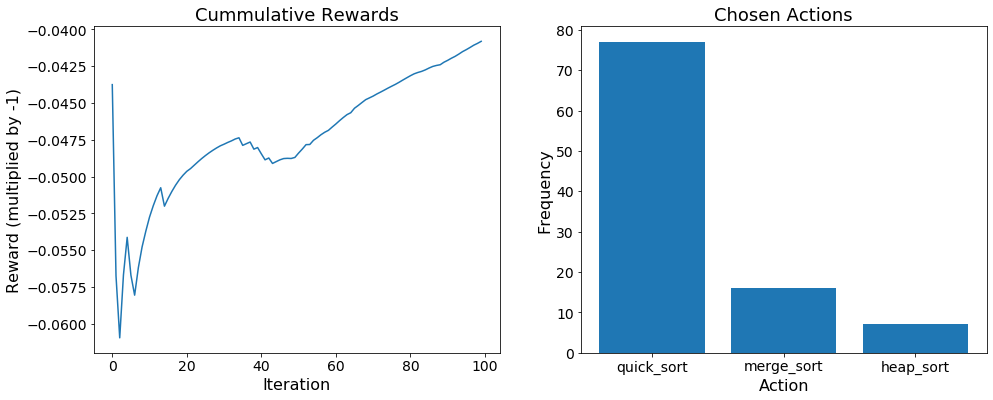

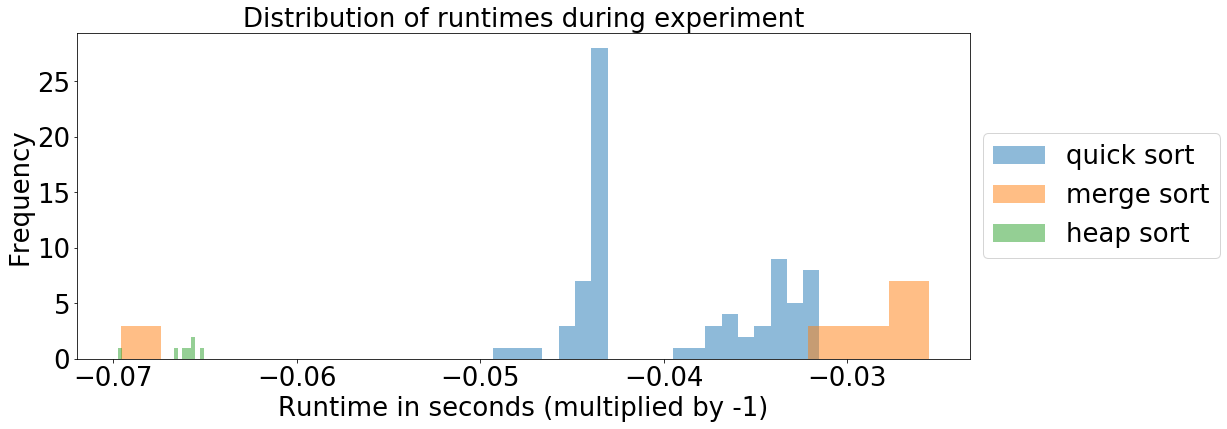

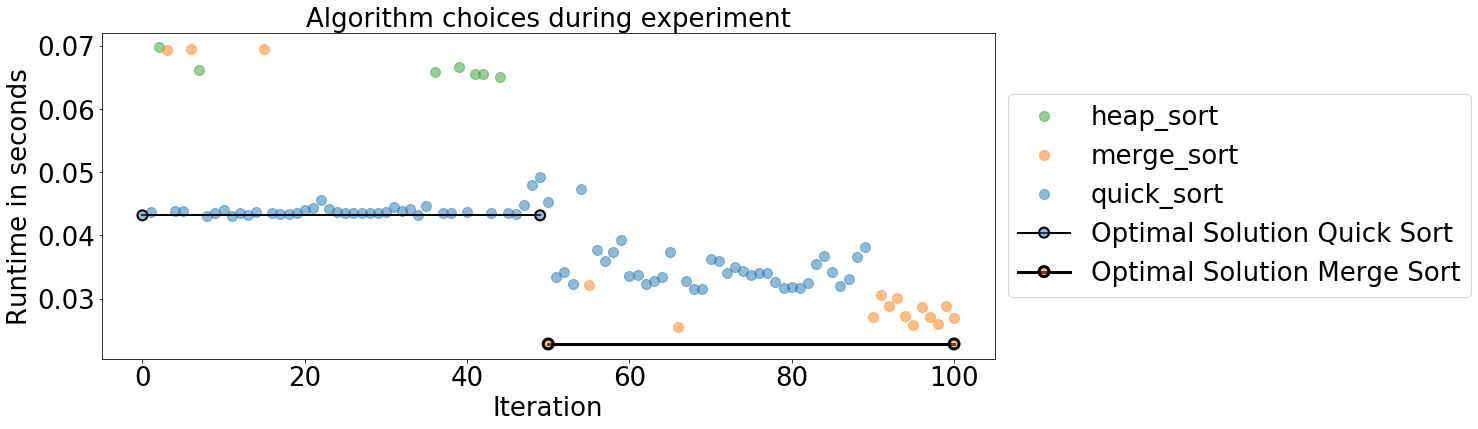

In [26]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history = epsilon_greedy(list_distributions_2, n_samples_5e5, epsilon=0.1, constant_value=0.5)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)

#### epsilon = 0.1, constant_value = 0.9

Total reward -4.441373000000397


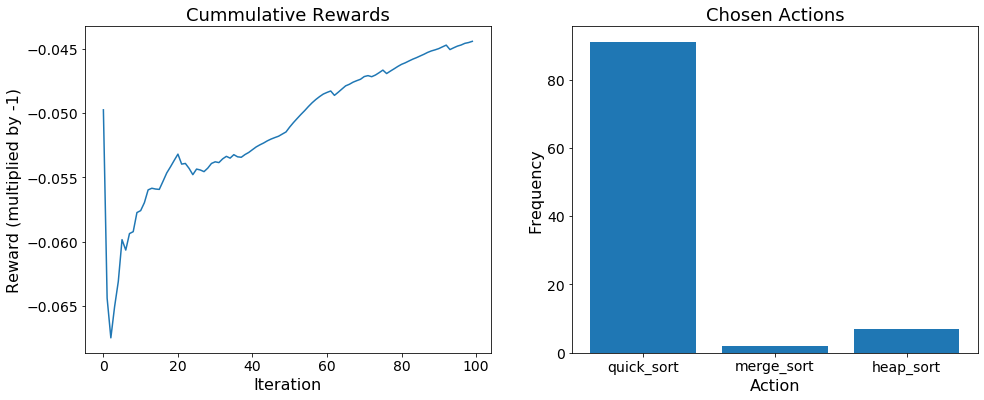

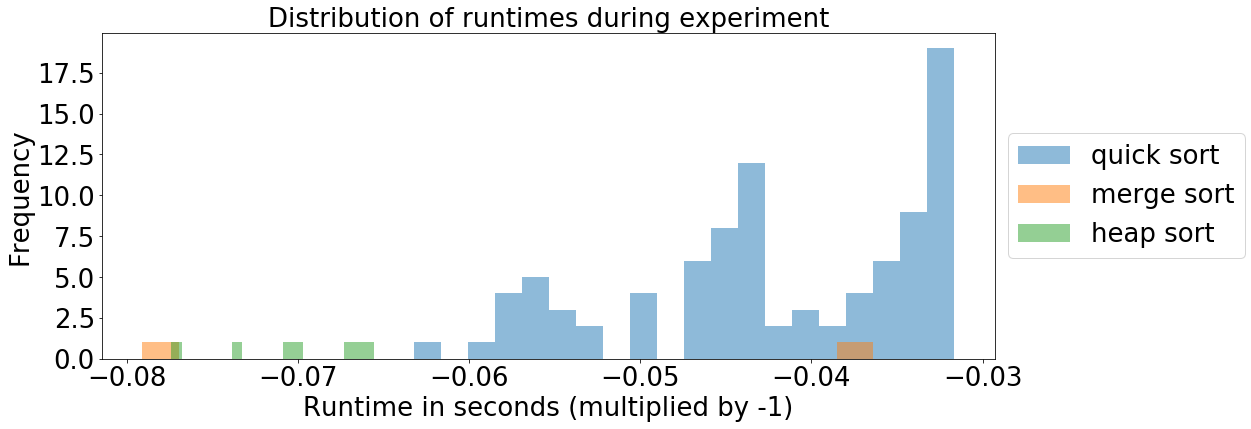

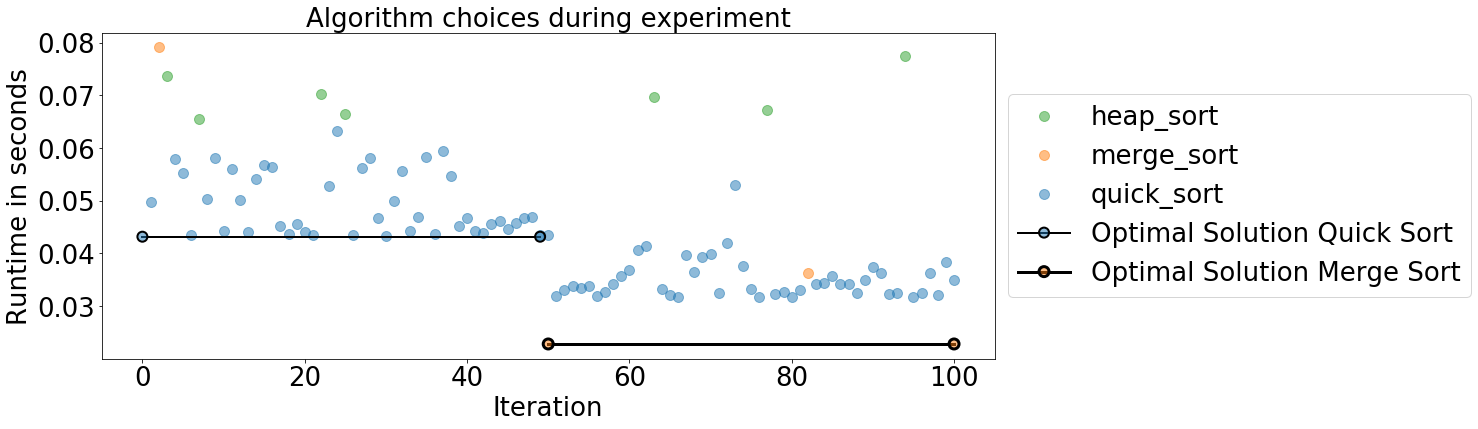

In [27]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history = epsilon_greedy(list_distributions_2, n_samples_5e5, epsilon=0.1, constant_value=0.9)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)

#### epsilon = 0.1, constant_value = 1

Total reward -4.210639199999889


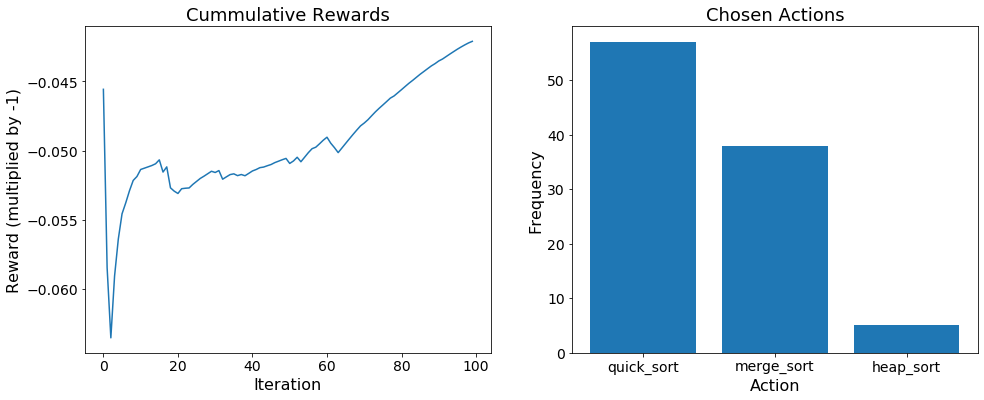

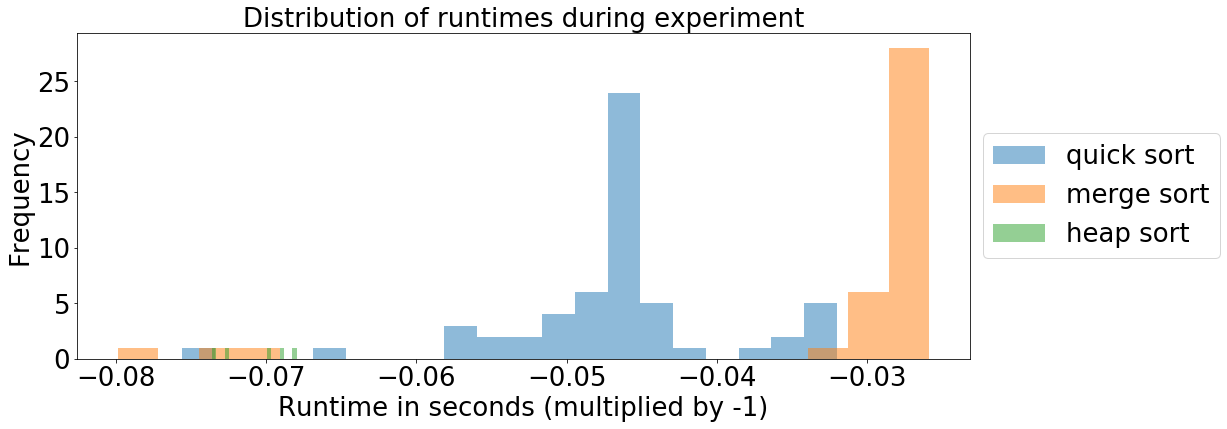

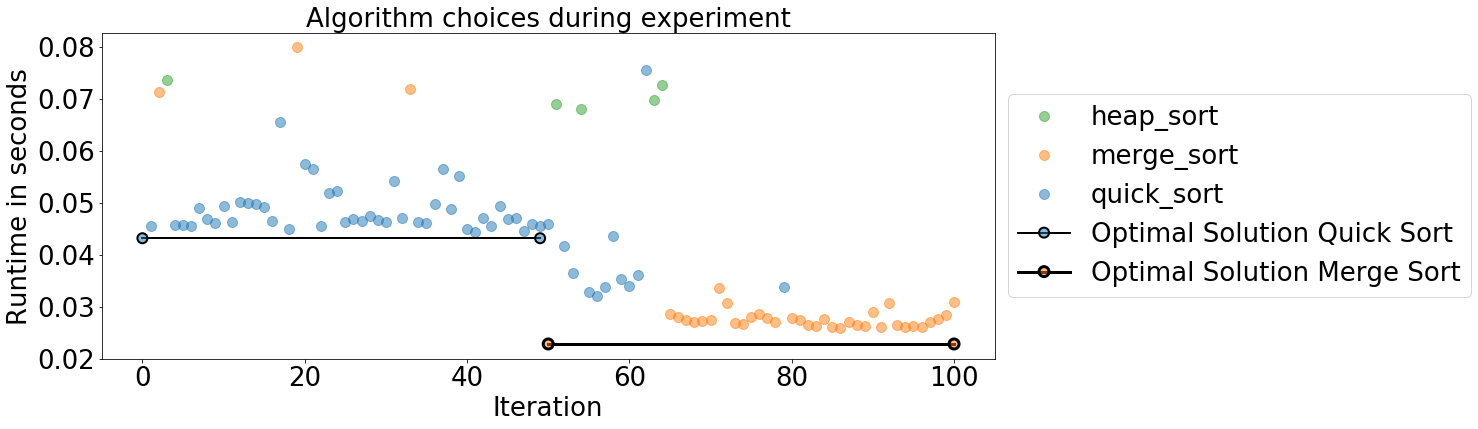

In [28]:
total_reward, arm_rewards, arm_counts, cum_rewards, rewards, history = epsilon_greedy(list_distributions_2, n_samples_5e5, epsilon=0.1, constant_value=1)
plot_history(rewards,cum_rewards, arm_counts)
plot_rewards_distribution_together(arm_rewards)
plot_history_iterations(history)
print("Total reward", total_reward)